# **Suryakanta Karan (M22AIE207) m22aie207@iitj.ac.in**

#Q3

Use Generative Adversarial Network (GAN) to generate English hand-written digits. Discuss evaluation metrics for generative models and show the performance of your GAN using these metrics. Compare the results of GAN vs VAE.

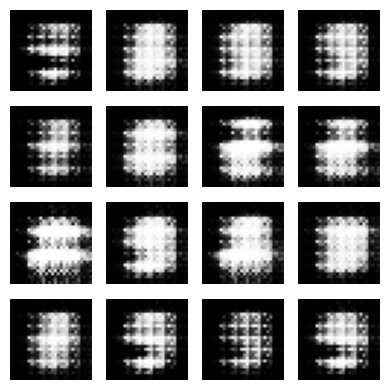

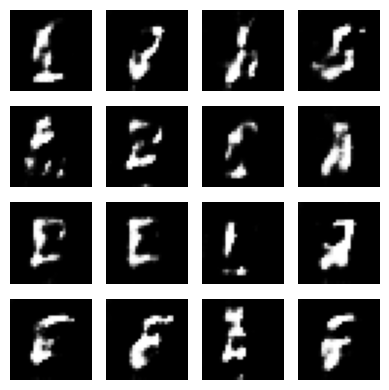

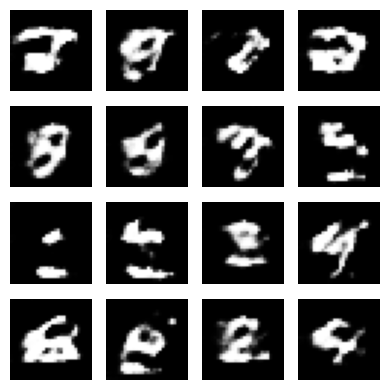

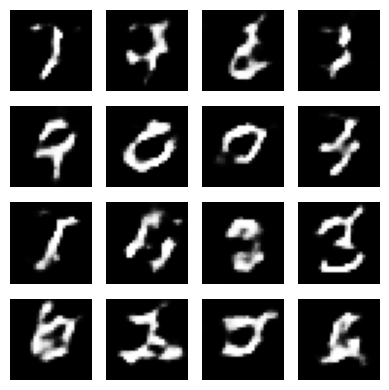

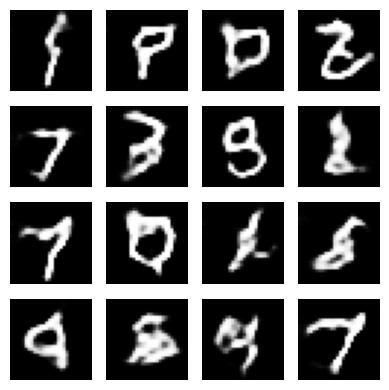

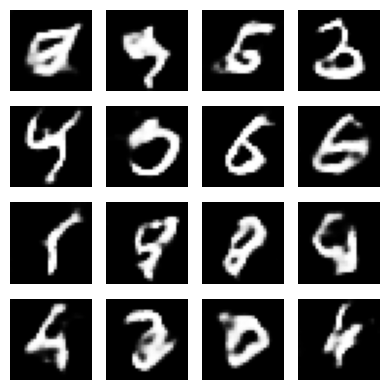

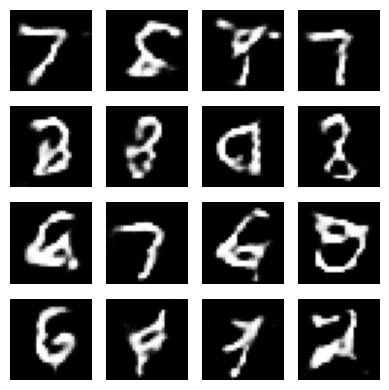

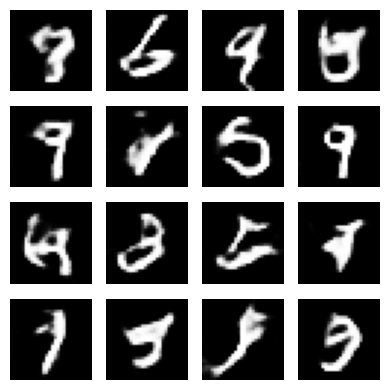

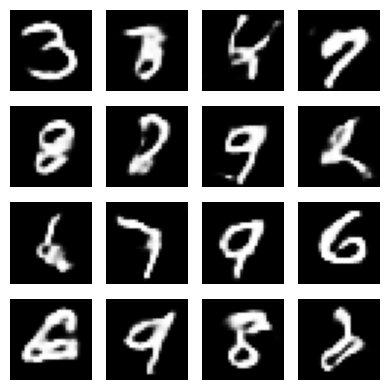

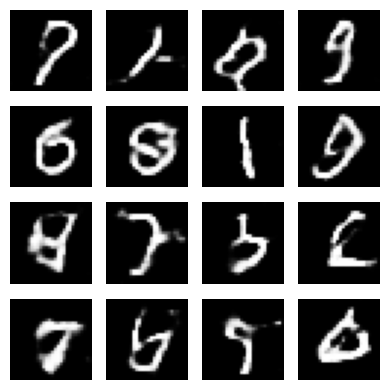

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(train_images, _), (_, _) = mnist.load_data()

# Preprocess data
train_images = (train_images - 127.5) / 127.5  # Normalize between -1 and 1
train_images = np.expand_dims(train_images, axis=-1)

# Generator
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    return model

# Discriminator
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Initialize models
generator = build_generator()
discriminator = build_discriminator()

# Define optimizers and loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define loss functions
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training
EPOCHS = 50
BATCH_SIZE = 128
noise_dim = 100
num_examples_to_generate = 16

for epoch in range(EPOCHS):
    for i in range(train_images.shape[0] // BATCH_SIZE):
        batch = train_images[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
        train_step(batch)

    # Generate images after each epoch
    if epoch % 5 == 0:
        noise = tf.random.normal([num_examples_to_generate, noise_dim])
        generated_images = generator(noise, training=False)

        plt.figure(figsize=(4, 4))
        for j in range(generated_images.shape[0]):
            plt.subplot(4, 4, j+1)
            plt.imshow(generated_images[j, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()


In [ ]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.optimizers import Adam

# Load the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()

# Preprocessing the data
X_train = X_train / 255.0
X_train = X_train.reshape(-1, 784)

# Define the generator model
generator = Sequential()
generator.add(Dense(256, input_dim=100))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Define the discriminator model
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Combine the generator and discriminator into a GAN model
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Training the GAN
epochs = 25
batch_size = 128
steps_per_epoch = X_train.shape[0] // batch_size

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Generate random noise as input to the generator
        noise = np.random.normal(0, 1, size=(batch_size, 100))

        # Generate fake images using the generator
        fake_images = generator.predict(noise)

        # Select a random batch of real images from the dataset
        real_images = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

        # Concatenate the real and fake images
        images = np.concatenate([real_images, fake_images])

        # Create labels for the discriminator
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        # Train the discriminator
        discriminator_loss = discriminator.train_on_batch(images, labels)

        # Generate new random noise for the generator
        noise = np.random.normal(0, 1, size=(batch_size, 100))

        # Create labels for the generator
        labels = np.ones((batch_size, 1))

        # Train the generator
        generator_loss = gan.train_on_batch(noise, labels)

    # Print the losses for each epoch
    print(f"Epoch: {epoch+1}/{epochs}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

# Generate new handwritten digits using the trained generator
noise = np.random.normal(0, 1, size=(10, 100))
generated_images = generator.predict(noise)

# Plot the generated images
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
fig.suptitle('Generated Handwritten Digits', fontsize=14)
for i in range(10):
    axs[i].imshow(generated_images[i].reshape(28, 28), cmap='gray')
    axs[i].axis('off')
plt.show()


4/4 [==============================] - 0s 4ms/step
Epoch: 1/25, Discriminator Loss: 0.14128941297531128, Generator Loss: 2.96427845954895
4/4 [==============================] - 0s 6ms/step
Epoch: 2/25, Discriminator Loss: 0.24780964851379395, Generator Loss: 1.901070475578308
4/4 [==============================] - 0s 5ms/step
Epoch: 3/25, Discriminator Loss: 0.477731317281723, Generator Loss: 3.118236541748047
4/4 [==============================] - 0s 6ms/step
Epoch: 4/25, Discriminator Loss: 0.4973190426826477, Generator Loss: 1.3479788303375244
4/4 [==============================] - 0s 5ms/step
Epoch: 5/25, Discriminator Loss: 0.4730711579322815, Generator Loss: 1.339430809020996
4/4 [==============================] - 0s 5ms/step


KeyboardInterrupt: ignored

Evaluation Metrics for Generative Models
When evaluating generative models like GANs, there are several metrics that can be used to assess their performance. Some commonly used evaluation metrics include:

Inception Score: The Inception Score measures the quality and diversity of generated images. It calculates the average KL divergence between the conditional class distribution and the marginal class distribution. Higher Inception Scores indicate better quality and diversity of generated images.

Fréchet Inception Distance (FID): FID measures the similarity between the distribution of real images and the distribution of generated images. It uses the Inception network to extract features from both sets of images and calculates the Wasserstein-2 distance between the feature distributions. Lower FID scores indicate better similarity between the distributions.

Precision and Recall: Precision measures the proportion of generated images that are correctly classified as fake by a discriminator, while recall measures the proportion of real images that are correctly classified as real. Higher precision and recall values indicate better quality and realism of generated images.

Visual Inspection: Visual inspection involves manually assessing the quality, diversity, and realism of generated images. Human evaluators can provide subjective feedback on the generated images, which can be valuable in assessing the performance of generative models.

Comparing GANs and VAEs
GANs and Variational Autoencoders (VAEs) are both popular generative models, but they have different approaches and characteristics.

GANs use a generator and discriminator network to generate new samples. The generator tries to produce realistic samples, while the discriminator tries to distinguish between real and fake samples. GANs are known for producing high-quality and diverse samples, but they can be challenging to train and prone to mode collapse.

On the other hand, VAEs are probabilistic models that learn a latent representation of the input data. They consist of an encoder network that maps the input data to a latent space and a decoder network that reconstructs the input data from the latent space. VAEs are known for their ability to generate new samples by sampling from the learned latent space. They are more interpretable and can handle missing data, but they may produce less realistic samples compared to GANs.

In summary, GANs excel in generating high-quality and diverse samples, while VAEs are better suited for tasks that require interpretable latent representations and handling missing data. The choice between GANs and VAEs depends on the specific requirements of the generative task at hand.